<a href="https://colab.research.google.com/github/hitanshu5/Crop-Yield-Prediction-System/blob/main/Crop_DynamicBayesianNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pgmpy==0.1.12

In [ ]:
!pip install --upgrade pgmpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import DynamicBayesianNetwork, BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import DBNInference
from pgmpy.factors.discrete import TabularCPD
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from tqdm import tqdm
import warnings
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
import statsmodels.api as sm
from networkx.drawing.nx_pydot import graphviz_layout

warnings.filterwarnings("ignore")

if not hasattr(np, "product"):
    np.product = np.prod

if not hasattr(np, "float_"):
    np.float_ = np.float64

In [ ]:
def create_time_sequence(df):
    season_map = {1: "Autumn", 2: "Kharif", 3: "Rabi", 4: "Summer"}
    df["TimeStep"] = df["Year"].astype(str) + "_" + df["Season"].map(season_map)
    season_order = {1: 0, 2: 1, 3: 2, 4: 3}
    df["TimeIndex"] = ((df["Year"] - df["Year"].min()) * 4 +
                       df["Season"].apply(lambda x: season_order[x]))
    return df.sort_values("TimeIndex")

def discretize_data(df, continuous_cols, n_bins=5):
    df_disc = df.copy()
    discretizers = {}
    for col in continuous_cols:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal",
                                       strategy="quantile")
        df_disc[f"{col}_disc"] = discretizer.fit_transform(df[[col]]).astype(int)
        discretizers[col] = discretizer
    return df_disc, discretizers

def convert_columns_str_to_tuple(df):
    new_columns = {}
    for col in df.columns:
        if isinstance(col, str) and "_" in col:
            parts = col.rsplit("_", 1)
            if len(parts) == 2 and parts[1].isdigit():
                new_columns[col] = (parts[0], int(parts[1]))
            else:
                new_columns[col] = col
        else:
            new_columns[col] = col
    return df.rename(columns=new_columns)

def change_time(node_str, new_time):
    parts = node_str.rsplit("_", 1)
    return f"{parts[0]}_{new_time}"

def str_to_tuple(node_str):
    parts = node_str.rsplit("_", 1)
    return (parts[0], int(parts[1]))

In [ ]:
def prepare_transition_data(df_remap, all_vars, cutoff_year):
    """
    Groups the remapped DataFrame by 'District' and 'Crop' to form consecutive time‑slice pairs.
    """
    train_data = df_remap[df_remap["Year_cat"] < cutoff_year].copy()
    dbn_train_data = []
    grouped = train_data.groupby(["District", "Crop"])
    for _, group in tqdm(grouped, desc="Preparing transitions"):
        group = group.sort_values("TimeIndex")
        for i in range(len(group) - 1):
            current = group.iloc[i]
            next_slice = group.iloc[i + 1]
            if next_slice["TimeIndex"] == current["TimeIndex"] + 1:
                row = {}
                for var in all_vars:
                    row[f"{var}_0"] = int(current[var])
                    row[f"{var}_1"] = int(next_slice[var])
                dbn_train_data.append(row)
    dbn_train_df = pd.DataFrame(dbn_train_data)
    return dbn_train_df

In [ ]:
def learn_dbn_structure_auto(dbn_train_df, all_vars):
    slice0_cols = [f"{var}_0" for var in all_vars]
    print("Learning intra-slice structure (time slice 0)...")
    hc_intra = HillClimbSearch(dbn_train_df[slice0_cols])
    static_model = hc_intra.estimate(scoring_method="bicscore")
    learned_intra_edges = list(static_model.edges())
    print("Learned intra-slice edges (time slice 0):")
    print(learned_intra_edges)

    intra_edges_t1 = [(change_time(u, 1), change_time(v, 1))
                      for u, v in learned_intra_edges]

    all_cols = slice0_cols + [f"{var}_1" for var in all_vars]
    disallowed_edges = []
    for s in [0, 1]:
        for t in [0, 1]:
            if not (s == 0 and t == 1):
                for a in all_vars:
                    for b in all_vars:
                        disallowed_edges.append((f"{a}_{s}", f"{b}_{t}"))
    print(f"Total disallowed edges for inter-slice learning: {len(disallowed_edges)}")
    print("Learning inter-slice edges (t0 -> t1 only)...")
    hc_inter = HillClimbSearch(dbn_train_df[all_cols])
    inter_model = hc_inter.estimate(scoring_method="bicscore",
                                    black_list=disallowed_edges)
    learned_inter_edges = [edge for edge in inter_model.edges()
                           if edge[0].endswith("_0") and edge[1].endswith("_1")]
    print("Learned inter-slice edges:")
    print(learned_inter_edges)
    return learned_intra_edges, intra_edges_t1, learned_inter_edges

def build_dbn_from_learned_structure(learned_intra_edges, intra_edges_t1, learned_inter_edges):
    dbn = DynamicBayesianNetwork()
    intra_edges_t0_tuples = [ (str_to_tuple(u), str_to_tuple(v))
                             for u, v in learned_intra_edges ]
    intra_edges_t1_tuples = [ (str_to_tuple(u), str_to_tuple(v))
                             for u, v in intra_edges_t1 ]
    inter_edges_tuples = [ (str_to_tuple(u), str_to_tuple(v))
                          for u, v in learned_inter_edges ]
    all_edges = intra_edges_t0_tuples + intra_edges_t1_tuples + inter_edges_tuples
    print("Building DBN using the learned edges...")
    for edge in all_edges:
        try:
            dbn.add_edge(edge[0], edge[1])
        except Exception as e:
            print(f"Error adding edge {edge}: {e}")
    print(f"DBN built with {len(dbn.edges())} edges.")
    return dbn

In [ ]:
def visualize_dbn_enhanced(dbn, title="Dynamic Bayesian Network", save_path=None):
    plt.figure(figsize=(15, 10))
    var_order = {
        "Year_cat": 8,
        "District": 7,
        "Crop": 6,
        "Season": 5,
        "Area_disc": 4,
        "Temperature_disc": 3,
        "Rainfall_disc": 2,
        "Yield_disc": 1,
    }
    pos = {}
    for node in dbn.nodes():
        var, t = node
        x = 2 if t == 0 else 7
        y = var_order.get(var, 0) * 1.5
        pos[node] = (x, y)
    node_colors = []
    for node in dbn.nodes():
        var = node[0]
        if var == "Yield_disc":
            node_colors.append("#ff9999")
        elif var in ["Area_disc", "Temperature_disc", "Rainfall_disc"]:
            node_colors.append("#99ccff")
        else:
            node_colors.append("#ccffcc")
    nx.draw_networkx_nodes(dbn, pos, node_size=2500, node_color=node_colors,
                           edgecolors="black", linewidths=1.5)
    labels = {node: f"{node[0]}\n(t{node[1]})" for node in dbn.nodes()}
    nx.draw_networkx_labels(dbn, pos, labels, font_size=11, font_weight="bold")
    for edge in dbn.edges():
        src, dst = edge
        style = "solid" if src[1] == dst[1] else "dashed"
        color = "#0066cc" if src[1] == dst[1] else "#cc3300"
        nx.draw_networkx_edges(dbn, pos, edgelist=[edge], arrows=True,
                               arrowstyle="-|>", arrowsize=20,
                               edge_color=color, style=style, width=2, alpha=0.8)
    ax = plt.gca()
    ax.add_patch(plt.Rectangle((0, -1), 4, 14, color="#eeeeee", alpha=0.5, zorder=-100))
    ax.add_patch(plt.Rectangle((5, -1), 4, 14, color="#f5f5f5", alpha=0.5, zorder=-100))
    plt.text(2, 13, "Time Slice 0", fontsize=14, ha="center", weight="bold")
    plt.text(7, 13, "Time Slice 1", fontsize=14, ha="center", weight="bold")

    node_legend_elements = [
        mpatches.Patch(color="#ff9999", label="Target (Yield)"),
        mpatches.Patch(color="#99ccff", label="Continuous Variables"),
        mpatches.Patch(color="#ccffcc", label="Categorical Variables"),
    ]
    edge_legend_elements = [
        mpatches.Patch(color="#0066cc", label="Intra-slice Dependency"),
        mpatches.Patch(color="#cc3300", label="Inter-slice Dependency"),
    ]
    plt.legend(handles=node_legend_elements + edge_legend_elements,
               loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
    plt.title(title, fontsize=18, weight="bold", pad=20)
    plt.axis("off")
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()
    return pos

def visualize_dbn_graphviz(dbn, title="DBN - Graphviz Hierarchical Layout", save_path=None):
    G = nx.DiGraph()
    for edge in dbn.edges():
        src, dst = edge
        src_label = f"{src[0]}_T{src[1]}"
        dst_label = f"{dst[0]}_T{dst[1]}"
        edge_style = "solid" if src[1] == dst[1] else "dashed"
        color = "#0066cc" if src[1] == dst[1] else "#cc3300"
        G.add_edge(src_label, dst_label, color=color, style=edge_style, weight=2)
    pos = graphviz_layout(G, prog="dot")
    plt.figure(figsize=(15, 12))
    node_colors = []
    for node in G.nodes():
        var = node.split("_T")[0]
        if var == "Yield_disc":
            node_colors.append("#ff9999")
        elif var in ["Area_disc", "Temperature_disc", "Rainfall_disc"]:
            node_colors.append("#99ccff")
        else:
            node_colors.append("#ccffcc")
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color=node_colors,
                           edgecolors="black", linewidths=1.5, alpha=0.8)
    edge_colors = [G[u][v]["color"] for u, v in G.edges()]
    for (u, v), color in zip(G.edges(), edge_colors):
        style = "dashed" if G[u][v]["style"] == "dashed" else "solid"
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2.0,
                               edge_color=[color], style=style,
                               arrows=True, arrowsize=20, arrowstyle='-|>', alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")
    plt.legend(handles=[
        mpatches.Patch(color="#ff9999", label="Target (Yield)"),
        mpatches.Patch(color="#99ccff", label="Continuous Variables"),
        mpatches.Patch(color="#ccffcc", label="Categorical Variables"),
        mpatches.Patch(color="#0066cc", label="Intra-slice Dependency"),
        mpatches.Patch(color="#cc3300", label="Inter-slice Dependency")
    ], loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
    plt.title(title, fontsize=18, weight="bold")
    plt.axis("off")
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()
    return pos

In [ ]:
def visualize_cpd(cpd, remap_dicts):
    if isinstance(cpd.variable, tuple):
        var_name, time_slice = cpd.variable
    else:
        parts = str(cpd.variable).rsplit('_', 1)
        if len(parts) == 2 and parts[1].isdigit():
            var_name, time_slice = parts[0], int(parts[1])
        else:
            var_name, time_slice = cpd.variable, "Unknown"

    plt.figure(figsize=(12, 8))
    if hasattr(cpd, 'evidence') and cpd.evidence:
        title = (f"CPD for {var_name} (t={time_slice}) | Conditions: "
                 f"{', '.join(str(e) for e in cpd.evidence)}")
    else:
        title = f"Prior for {var_name} (t={time_slice})"
    values = cpd.get_values()
    if values.ndim == 1:
        plt.bar(range(len(values)), values, color='skyblue', edgecolor='black')
        plt.xticks(range(len(values)), range(len(values)))
        plt.xlabel(f"States of {var_name}")
        plt.ylabel("Probability")
        if var_name in remap_dicts:
            state_info = "\nState mapping:\n"
            for i in range(len(values)):
                actual_val = remap_dicts[var_name]["reverse"].get(i, i)
                state_info += f"State {i} → {actual_val}\n"
            plt.figtext(0.02, 0.02, state_info, fontsize=10, ha='left')
    else:
        if values.ndim == 2:
            plt.imshow(values, cmap='viridis', aspect='auto')
            plt.colorbar(label='Probability')
            if hasattr(cpd, 'evidence') and len(cpd.evidence) == 1:
                plt.xlabel(f"States of {cpd.evidence[0]}")
            else:
                plt.xlabel("Parent State Combination")
            plt.ylabel(f"States of {var_name}")
        else:
            rows = cpd.variable_card
            cols = int(np.prod(values.shape) // rows)
            reshaped_values = values.reshape(rows, cols)
            plt.imshow(reshaped_values, cmap='viridis', aspect='auto')
            plt.colorbar(label='Probability')
            plt.xlabel("Parent State Combinations")
            plt.ylabel(f"States of {var_name}")
            evidence_str = ", ".join(str(e) for e in cpd.evidence)
            plt.figtext(0.5, 0.01,
                        (f"Note: This is a {values.ndim}D distribution reshaped to 2D.\n"
                         f"Parent variables: {evidence_str}\n"
                         f"Parent cardinalities: {cpd.evidence_card}"),
                        fontsize=10, ha='center')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def build_continuous_bn(df):
    BN_structure = {
        "District": [],
        "Season": [],
        "Year": [],
        "Crop": [],
        "Area": [],
        "Temperature": ["District", "Season"],
        "Rainfall": ["District", "Season"],
        "Yield": ["District", "Season", "Crop", "Area", "Year", "Temperature", "Rainfall"],
    }
    cpds_BN = {}
    for node, parents in BN_structure.items():
        if len(parents) == 0:
            mu = df[node].mean()
            var = df[node].var()
            cpds_BN[node] = {"mean": mu, "variance": var}
        else:
            if node == "Yield":
                formula = "Yield ~ District + Season + Area + Year + Temperature + Rainfall + C(Crop)"
                model_fitted = sm.OLS.from_formula(formula, data=df).fit()
                cpds_BN[node] = {"model": model_fitted, "params": model_fitted.params,
                                 "sigma": np.sqrt(model_fitted.mse_resid)}
            else:
                X = df[parents]
                X = sm.add_constant(X)
                y = df[node]
                model_fitted = sm.OLS(y, X).fit()
                cpds_BN[node] = {"model": model_fitted, "params": model_fitted.params,
                                 "sigma": np.sqrt(model_fitted.mse_resid)}
    return BN_structure, cpds_BN

def predict_yield_bn(cpds_BN, test_input):
    crop_mapping = {
        1: "Cotton", 2: "Gram", 3: "Groundnut", 4: "Jowar", 5: "Maize",
        6: "Moong", 7: "Mustard", 8: "Rice", 9: "Sesamum", 10: "Small Millets",
        11: "Soyabean", 12: "Sugarcane", 13: "Sunflower", 14: "Tur", 15: "Urad"
    }
    yield_model = cpds_BN["Yield"]["model"]
    predictions = {}
    print("\n=== BN Predicted Yields for Each Crop ===\n")
    for crop_code in range(1, 16):
        test_df = pd.DataFrame({
            "District": [test_input["District"]],
            "Season": [test_input["Season"]],
            "Crop": [crop_code],
            "Area": [test_input["Area"]],
            "Year": [test_input["Year"]],
            "Temperature": [test_input["Temperature"]],
            "Rainfall": [test_input["Rainfall"]]
        })
        predicted_yield = yield_model.predict(test_df)[0]
        predictions[crop_code] = predicted_yield
        print(f"Crop: {crop_mapping[crop_code]} (encoded {crop_code}): Predicted Yield = {predicted_yield:.4f}")
    sorted_predictions = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
    print("\n=== Crops Arranged by Descending Predicted Yield ===")
    for crop_code, pred in sorted_predictions:
        print(f"{crop_mapping[crop_code]}: {pred:.4f}")
    return predictions

In [ ]:
df = pd.read_csv("final_df.csv")
print("Data loaded. Shape:", df.shape)

df_time = create_time_sequence(df)
print("Time sequence created.")

continuous_vars = ["Area", "Temperature", "Rainfall", "Yield"]
df_disc, discretizers = discretize_data(df_time, continuous_vars, n_bins=5)
print("Continuous variables discretized.")

cols_to_convert = ["District", "Crop", "Season", "Year"] + [f"{var}_disc" for var in continuous_vars]
for col in cols_to_convert:
    df_disc[col] = df_disc[col].astype(int)

base_year = df_disc["Year"].min()
df_disc["Year_diff"] = df_disc["Year"] - base_year
bins = [0, 5, 10, 15, np.inf]
df_disc["Year_cat"] = pd.cut(df_disc["Year_diff"], bins=bins, labels=[0, 1, 2, 3],
                             right=False).astype(int)

all_vars = ["District", "Crop", "Season", "Year_cat", "Area_disc",
            "Temperature_disc", "Rainfall_disc", "Yield_disc"]

df_remap = df_disc.copy()
remap_dicts = {}
for var in all_vars:
    unique_vals = sorted(df_remap[var].unique())
    remap = {val: idx for idx, val in enumerate(unique_vals)}
    reverse_map = {idx: val for val, idx in remap.items()}
    df_remap[var] = df_remap[var].map(remap)
    remap_dicts[var] = {"forward": remap, "reverse": reverse_map}
    print(f"{var} remapped: {len(unique_vals)} states")

all_years_cat = sorted(df_remap["Year_cat"].unique())
train_years_count = int(len(all_years_cat) * 0.8)
cutoff_year_cat = all_years_cat[train_years_count]
print(f"Training data: Year_cat < {cutoff_year_cat}")

Data loaded. Shape: (13904, 8)
Time sequence created.
Continuous variables discretized.
District remapped: 32 states
Crop remapped: 15 states
Season remapped: 4 states
Year_cat remapped: 4 states
Area_disc remapped: 5 states
Temperature_disc remapped: 5 states
Rainfall_disc remapped: 5 states
Yield_disc remapped: 5 states
Training data: Year_cat < 3


In [ ]:
dbn_train_df = prepare_transition_data(df_remap, all_vars, cutoff_year_cat)
print(f"Number of training transitions: {len(dbn_train_df)}")

learned_intra_edges, intra_edges_t1, learned_inter_edges = learn_dbn_structure_auto(dbn_train_df, all_vars)

dbn_auto = build_dbn_from_learned_structure(learned_intra_edges, intra_edges_t1,
                                              learned_inter_edges)

dbn_train_df = convert_columns_str_to_tuple(dbn_train_df)

def convert_dbn_to_bayesian_model_str(dbn):
    edges = []
    for u, v in dbn.edges():
        u_str = f"{u[0]}_{u[1]}"
        v_str = f"{v[0]}_{v[1]}"
        edges.append((u_str, v_str))
    bayes_model = BayesianModel(edges)
    return bayes_model

def convert_tuple_columns_to_str(df):
    new_df = df.copy()
    new_df.columns = [
        f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col
        for col in new_df.columns
    ]
    return new_df

bayes_model_str = convert_dbn_to_bayesian_model_str(dbn_auto)

dbn_train_df_str = convert_tuple_columns_to_str(dbn_train_df)

print("Bayesian model nodes:", bayes_model_str.nodes())
print("DataFrame columns:", dbn_train_df_str.columns.tolist())

print("\nLearning CPDs using Maximum Likelihood Estimation on the converted BayesianModel...")
bayes_model_str.fit(dbn_train_df_str, estimator=MaximumLikelihoodEstimator)
print("Discrete BN CPD Learning complete (via BayesianModel conversion).")

cpds_list = bayes_model_str.get_cpds()
print(f"\nNumber of CPDs in the model: {len(cpds_list)}")

if len(cpds_list) == 0:
    print("No CPDs were learned!")
else:
    print("\n==== DISCRETE BN CPDs ====")
    for cpd in cpds_list:
        print(f"\nCPD for {cpd.variable}:")
        if hasattr(cpd, 'evidence') and cpd.evidence:
            evidence_str = ", ".join(str(e) for e in cpd.evidence)
            print(f"Conditioned on: {evidence_str}")
            print(f"Evidence cardinalities: {cpd.evidence_card}")
        else:
            print("This is a prior probability")

        print(f"Variable cardinality: {cpd.variable_card}")
        print("Values shape:", cpd.values.shape)

        if cpd.values.ndim <= 2:
            try:
                from tabulate import tabulate
                print(tabulate(pd.DataFrame(cpd.values), headers="keys", tablefmt="psql"))
            except Exception as e:
                print("Error printing CPD table:", e)
        else:
            print(f"Mean probability: {cpd.values.mean():.4f}")
            print(f"Min probability: {cpd.values.min():.4f}")
            print(f"Max probability: {cpd.values.max():.4f}")

Preparing transitions: 100%|██████████| 439/439 [00:04<00:00, 100.98it/s]


Number of training transitions: 1598
Learning intra-slice structure (time slice 0)...


  0%|          | 7/1000000 [00:02<96:38:26,  2.87it/s]


Learned intra-slice edges (time slice 0):
[('District_0', 'Temperature_disc_0'), ('Crop_0', 'Yield_disc_0'), ('Crop_0', 'Rainfall_disc_0'), ('Season_0', 'Temperature_disc_0'), ('Area_disc_0', 'Crop_0'), ('Rainfall_disc_0', 'Season_0'), ('Rainfall_disc_0', 'District_0')]
Total disallowed edges for inter-slice learning: 192
Learning inter-slice edges (t0 -> t1 only)...


  0%|          | 12/1000000 [00:05<129:51:11,  2.14it/s]


Learned inter-slice edges:
[('District_0', 'District_1'), ('Crop_0', 'Crop_1'), ('Crop_0', 'Yield_disc_1'), ('Crop_0', 'Area_disc_1'), ('Season_0', 'Season_1'), ('Season_0', 'Temperature_disc_1'), ('Season_0', 'Area_disc_1'), ('Season_0', 'Rainfall_disc_1'), ('Season_0', 'Yield_disc_1'), ('Year_cat_0', 'Year_cat_1'), ('Year_cat_0', 'Temperature_disc_1'), ('Temperature_disc_0', 'Rainfall_disc_1')]
Building DBN using the learned edges...
DBN built with 26 edges.
Bayesian model nodes: ['District_0', 'Temperature_disc_0', 'District_1', 'Rainfall_disc_1', 'Temperature_disc_1', 'Crop_0', 'Yield_disc_0', 'Rainfall_disc_0', 'Crop_1', 'Yield_disc_1', 'Area_disc_1', 'Season_0', 'Season_1', 'Area_disc_0', 'Year_cat_0', 'Year_cat_1']
DataFrame columns: ['District_0', 'District_1', 'Crop_0', 'Crop_1', 'Season_0', 'Season_1', 'Year_cat_0', 'Year_cat_1', 'Area_disc_0', 'Area_disc_1', 'Temperature_disc_0', 'Temperature_disc_1', 'Rainfall_disc_0', 'Rainfall_disc_1', 'Yield_disc_0', 'Yield_disc_1']

Lea


==== DISCRETE BN CPDs ====

CPD for Area_disc_0:
This is a prior probability
Variable cardinality: 5
Values shape: (5,)
+----+----------+
|    |        0 |
|----+----------|
|  0 | 0.111389 |
|  1 | 0.277847 |
|  2 | 0.284105 |
|  3 | 0.18398  |
|  4 | 0.142678 |
+----+----------+
Mean probability: 0.2000
Min probability: 0.1114
Max probability: 0.2841

CPD for Area_disc_1:
This is a prior probability
Variable cardinality: 5
Values shape: (5, 5, 2)

CPD for Crop_0:
This is a prior probability
Variable cardinality: 5
Values shape: (5, 5)
+----+-----------+----------+-----------+-----------+-----------+
|    |         0 |        1 |         2 |         3 |         4 |
|----+-----------+----------+-----------+-----------+-----------|
|  0 | 0.0955056 | 0.045045 | 0.110132  | 0.292517  | 0.842105  |
|  1 | 0.151685  | 0.236486 | 0.297357  | 0.265306  | 0.0833333 |
|  2 | 0.129213  | 0.186937 | 0.0726872 | 0.0136054 | 0         |
|  3 | 0.230337  | 0.162162 | 0.0969163 | 0.0748299 | 0     

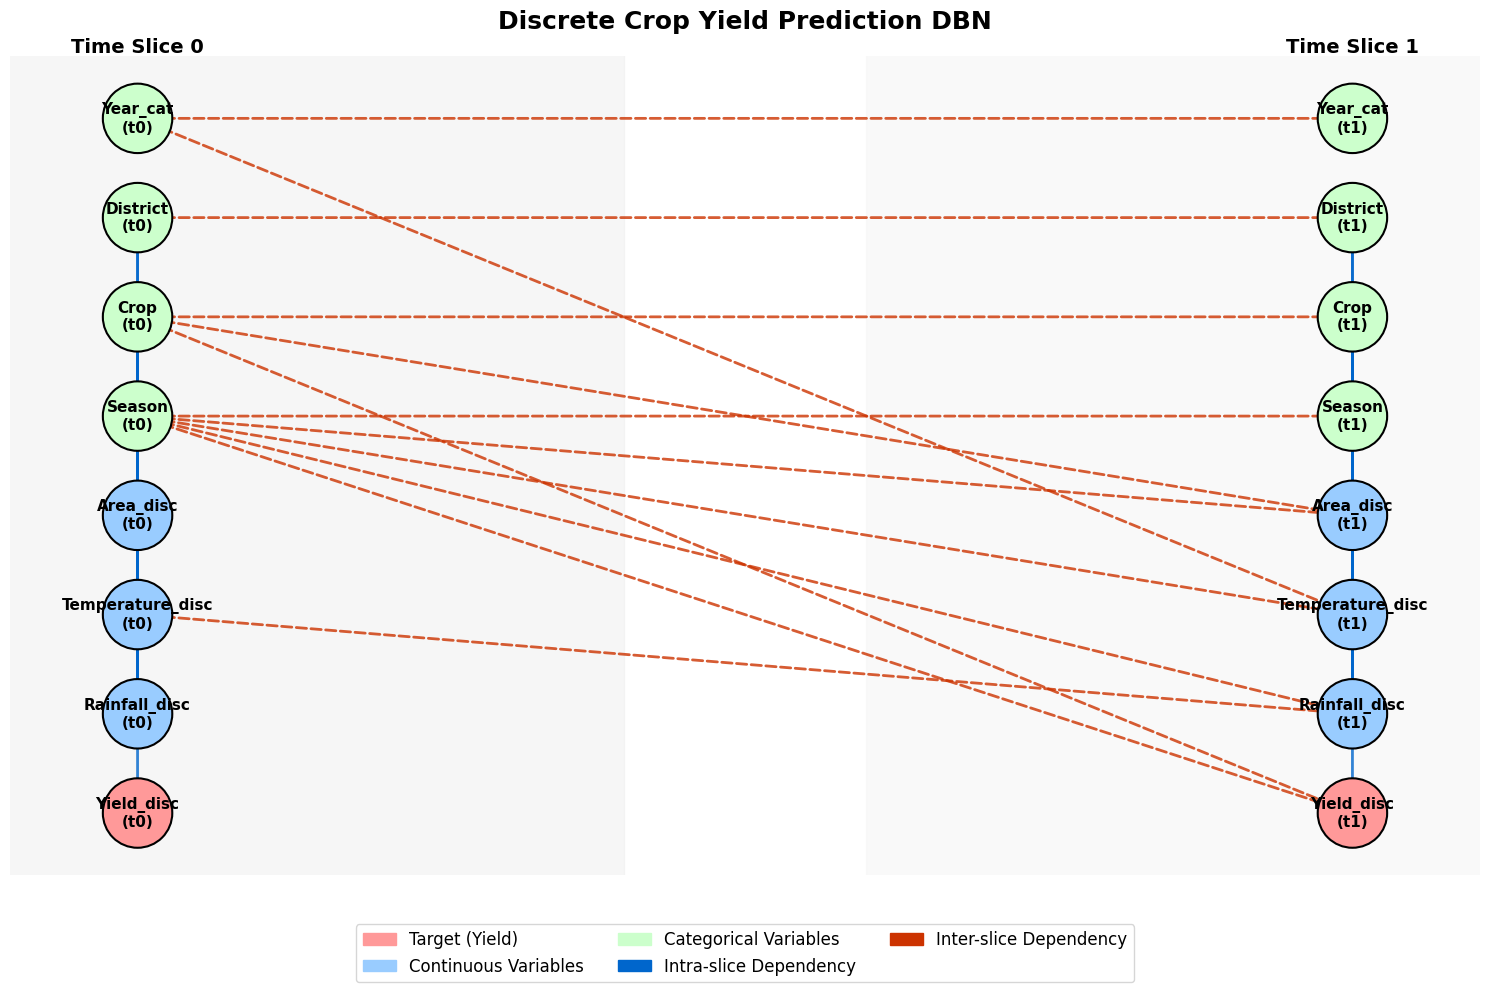


Visualizing the Discrete BN (Graphviz Hierarchical Layout):


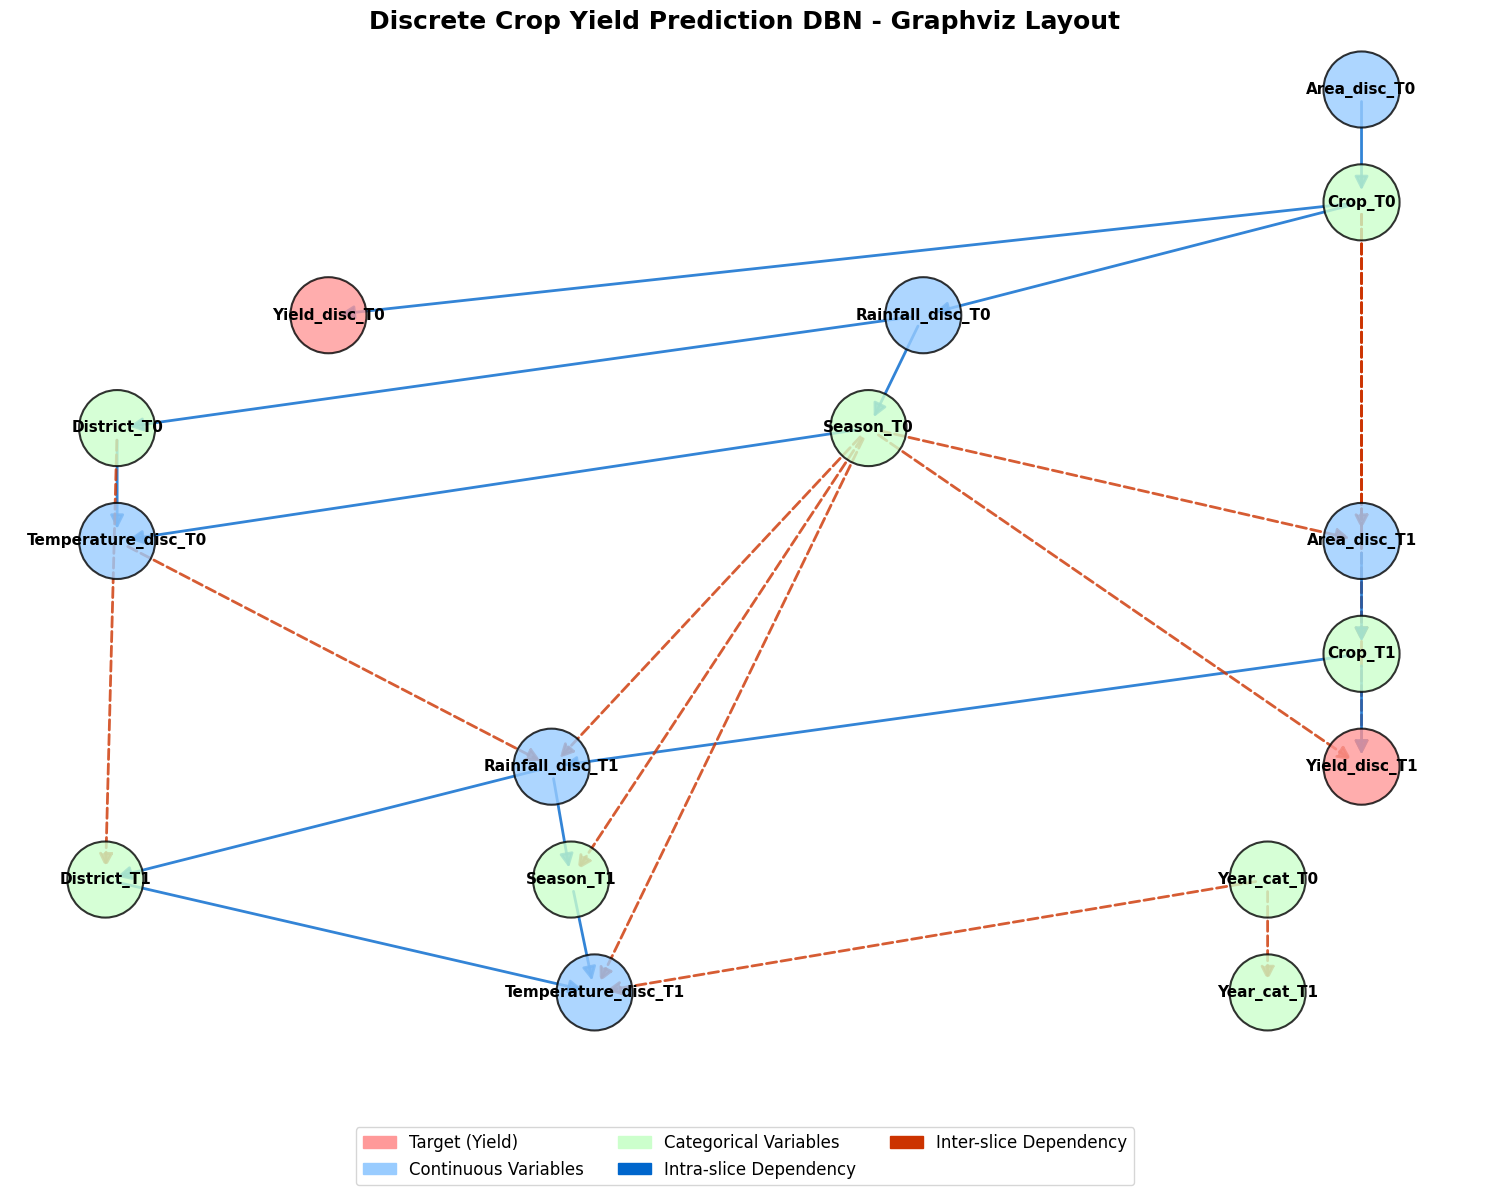

{'District_T0': (110.26, 378.0),
 'Temperature_disc_T0': (110.26, 306.0),
 'District_T1': (107.26, 90.0),
 'Rainfall_disc_T1': (221.26, 162.0),
 'Temperature_disc_T1': (232.26, 18.0),
 'Crop_T0': (428.26, 522.0),
 'Yield_disc_T0': (164.26, 450.0),
 'Rainfall_disc_T0': (316.26, 450.0),
 'Crop_T1': (428.26, 234.0),
 'Yield_disc_T1': (428.26, 162.0),
 'Area_disc_T1': (428.26, 306.0),
 'Season_T0': (302.26, 378.0),
 'Season_T1': (226.26, 90.0),
 'Area_disc_T0': (428.26, 594.0),
 'Year_cat_T0': (404.26, 90.0),
 'Year_cat_T1': (404.26, 18.0)}

In [ ]:
print("\n==== DISCRETE BN CPDs ====")
for cpd in cpds_list:
  print(f"\nCPD for {cpd.variable}:")
  if hasattr(cpd, 'evidence') and cpd.evidence:
    evidence_str = ", ".join(str(e) for e in cpd.evidence)
    print(f"Conditioned on: {evidence_str}")
    print(f"Evidence cardinalities: {cpd.evidence_card}")
  else:
    print("This is a prior probability")

    print(f"Variable cardinality: {cpd.variable_card}")
    print("Values shape:", cpd.values.shape)

    if cpd.values.ndim <= 2:
        try:
          from tabulate import tabulate
          print(tabulate(pd.DataFrame(cpd.values),
                               headers="keys",
                               tablefmt="psql"))
        except Exception as e:
          print("Error printing CPD table:", e)
        else:
            print(f"Mean probability: {cpd.values.mean():.4f}")
            print(f"Min probability: {cpd.values.min():.4f}")
            print(f"Max probability: {cpd.values.max():.4f}")

print("\nVisualizing the Discrete BN (Enhanced Layout):")
visualize_dbn_enhanced(dbn_auto, "Discrete Crop Yield Prediction DBN")

print("\nVisualizing the Discrete BN (Graphviz Hierarchical Layout):")
visualize_dbn_graphviz(dbn_auto, "Discrete Crop Yield Prediction DBN - Graphviz Layout")

In [ ]:
!pip install --upgrade pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

Dataset Information:
Shape: (13904, 8)

Columns:
['District', 'Crop', 'Year', 'Season', 'Area', 'Temperature', 'Rainfall', 'Yield']

Sample data:
   District  Crop  Year  Season      Area  Temperature  Rainfall     Yield
0         1     2  1997       2   40800.0    23.998425   112.450  0.455882
1         1     4  1997       2     900.0    23.998425   112.450  1.222222
2         1     4  1997       3  598400.0    21.448471     9.375  0.362634
3         1     5  1997       2    4400.0    23.998425   112.450  1.068182
4         1     5  1997       3    6200.0    21.448471     9.375  1.467742

Missing values:
District       0
Crop           0
Year           0
Season         0
Area           0
Temperature    0
Rainfall       0
Yield          0
dtype: int64

Crop Yield Statistics (by crop):
          mean    median       min       max
Crop                                        
12    1.610552  1.676389  0.799852  1.676389
5     1.435827  1.496377  0.000000  2.545455
1     1.307245  1.256325

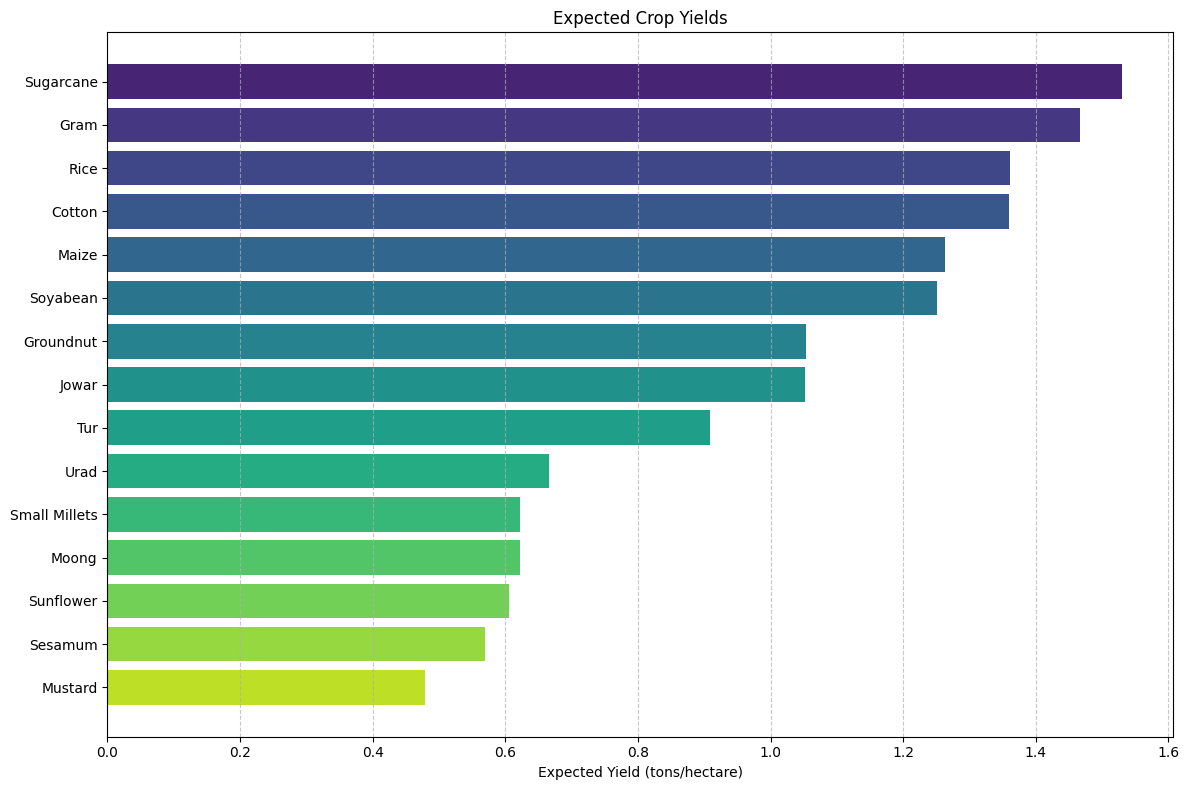

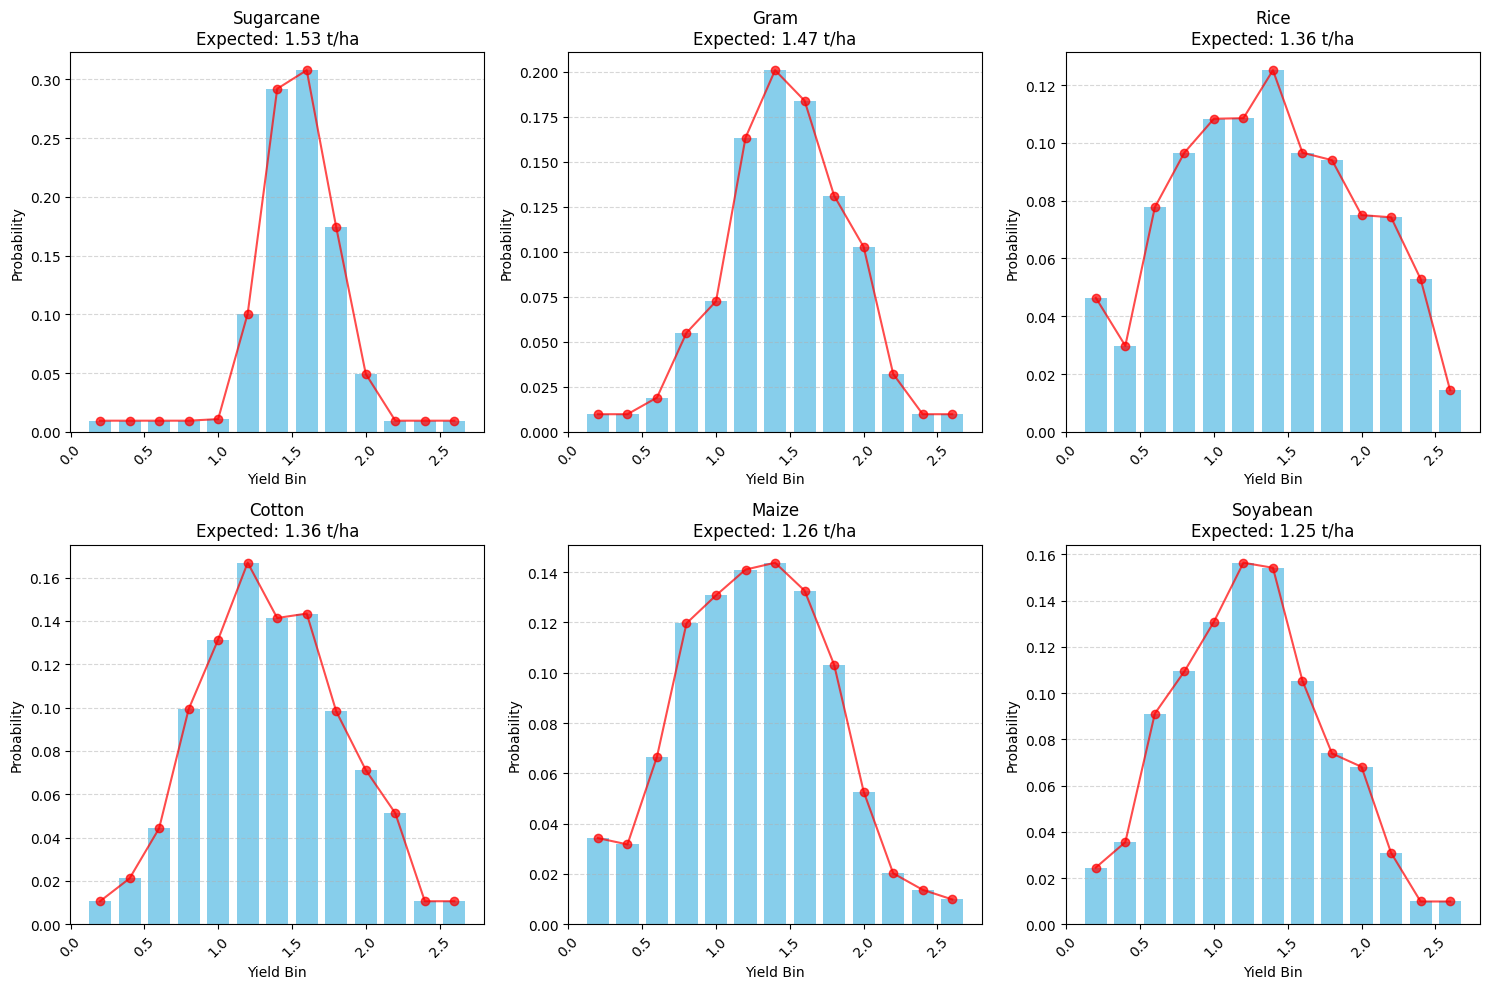

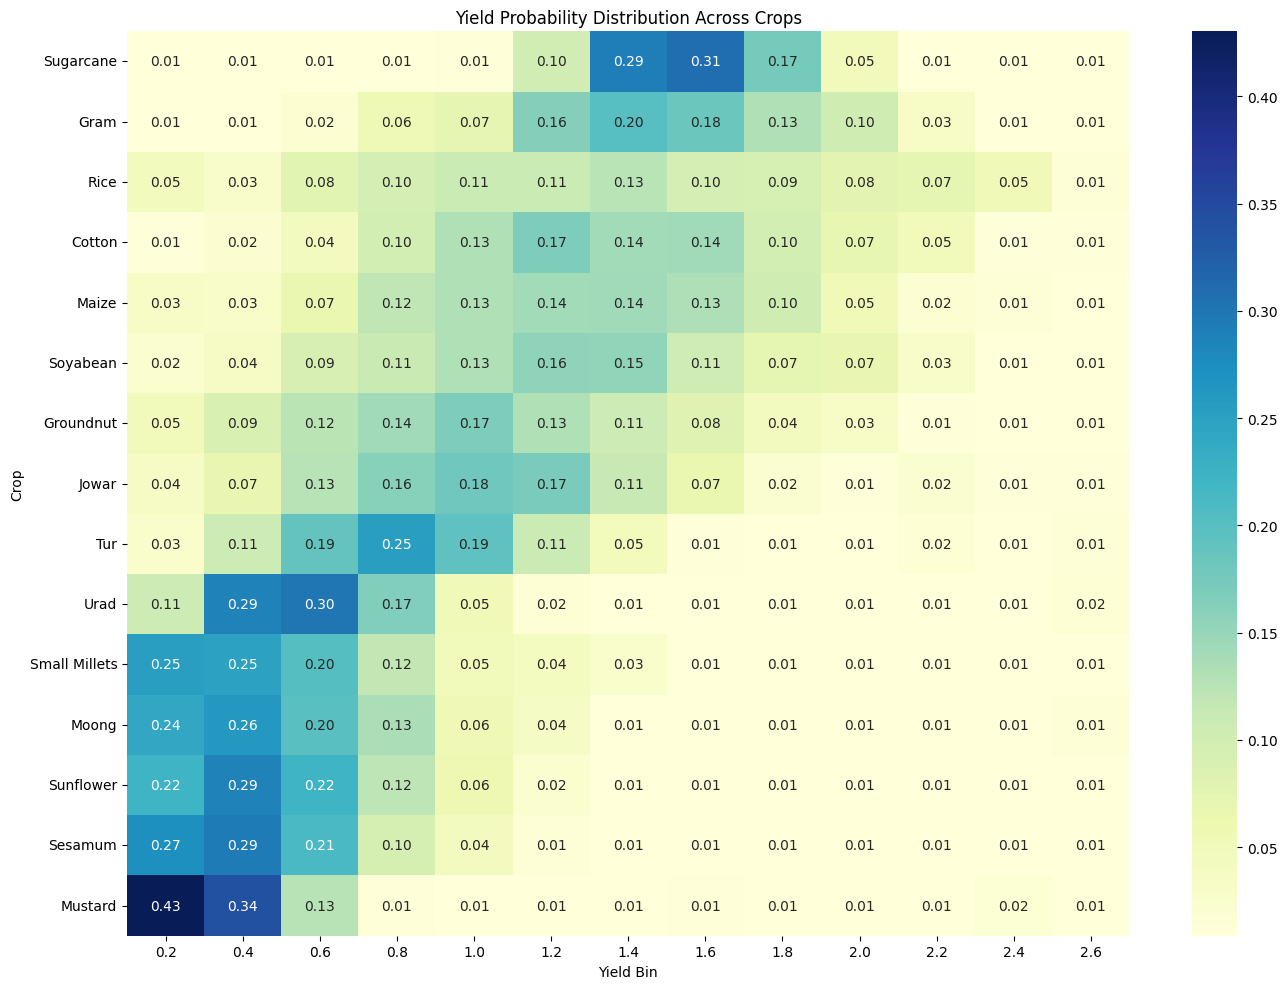

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import random
import warnings

warnings.filterwarnings('ignore')
random.seed(42)

global_dbn_predictions = []


def load_and_preprocess_data(file_path):
    """
    Load the CSV data and perform basic cleaning.
    """
    df = pd.read_csv(file_path)
    print("Dataset Information:")
    print(f"Shape: {df.shape}")
    print("\nColumns:")
    print(df.columns.tolist())
    print("\nSample data:")
    print(df.head())
    print("\nMissing values:")
    print(df.isnull().sum())

    df = df.dropna()
    return df


def discretize_data(df):
    """
    Discretize continuous variables with balanced binning strategies.
    """
    yield_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
    yield_labels = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]

    print("\nYield Distribution Analysis:")
    print(f"Min: {df['Yield'].min()}, Max: {df['Yield'].max()}, Mean: {df['Yield'].mean()}, "
          f"Median: {df['Yield'].median()}")

    # Reduced number of bins (to optimize memory but still provide discrimination)
    temp_bins = 8
    temp_labels = [f"T{i+1}" for i in range(temp_bins)]
    # Use qcut to obtain the bin edges based on data quantiles
    temp_edges = pd.qcut(df['Temperature'], q=temp_bins, retbins=True, duplicates='drop')[1]

    rain_bins = 8
    rain_labels = [f"R{i+1}" for i in range(rain_bins)]
    rain_edges = pd.qcut(df['Rainfall'], q=rain_bins, retbins=True, duplicates='drop')[1]

    # For Area, apply a natural log transform and then discretize into 6 bins.
    area_log = np.log1p(df['Area'])
    area_bins = 6
    area_labels = [f"A{i+1}" for i in range(area_bins)]
    area_log_edges = pd.qcut(area_log, q=area_bins, retbins=True, duplicates='drop')[1]

    crop_stats = {}
    for crop in df['Crop'].unique():
        crop_data = df[df['Crop'] == crop]
        crop_stats[crop] = {
            'mean': crop_data['Yield'].mean(),
            'median': crop_data['Yield'].median(),
            'std': crop_data['Yield'].std(),
            'min': crop_data['Yield'].min(),
            'max': crop_data['Yield'].max(),
            'q25': crop_data['Yield'].quantile(0.25),
            'q75': crop_data['Yield'].quantile(0.75),
            'count': len(crop_data)
        }

    district_crop_stats = {}
    for district in df['District'].unique():
        district_crop_stats[district] = {}
        for crop in df['Crop'].unique():
            subset = df[(df['District'] == district) & (df['Crop'] == crop)]
            if len(subset) > 0:
                district_crop_stats[district][crop] = {
                    'mean': subset['Yield'].mean(),
                    'std': subset['Yield'].std() if len(subset) > 1 else 0.2,
                    'count': len(subset)
                }

    season_crop_stats = {}
    for season in df['Season'].unique():
        season_crop_stats[season] = {}
        for crop in df['Crop'].unique():
            subset = df[(df['Season'] == season) & (df['Crop'] == crop)]
            if len(subset) > 0:
                season_crop_stats[season][crop] = {
                    'mean': subset['Yield'].mean(),
                    'std': subset['Yield'].std() if len(subset) > 1 else 0.2,
                    'count': len(subset)
                }

    bin_info = {
        'yield_bins': yield_bins,
        'yield_labels': yield_labels,
        'temp_edges': temp_edges,
        'temp_labels': temp_labels,
        'rain_edges': rain_edges,
        'rain_labels': rain_labels,
        'area_log_edges': area_log_edges,
        'area_labels': area_labels,
        'crop_stats': crop_stats,
        'district_crop_stats': district_crop_stats,
        'season_crop_stats': season_crop_stats
    }

    return bin_info


def map_input_to_bins(input_data, bin_info):
    """
    Map continuous test inputs to their discrete bin labels.
    """
    temp_edges = bin_info['temp_edges']
    rain_edges = bin_info['rain_edges']
    area_log_edges = bin_info['area_log_edges']

    temp_labels = bin_info['temp_labels']
    rain_labels = bin_info['rain_labels']
    area_labels = bin_info['area_labels']

    temperature = input_data['temperature']
    rainfall = input_data['rainfall']
    area = input_data['area']
    area_log = np.log1p(area)

    temp_bin = np.digitize(temperature, temp_edges) - 1
    temp_bin = min(max(0, temp_bin), len(temp_edges) - 2)
    temp_label = temp_labels[temp_bin]

    rain_bin = np.digitize(rainfall, rain_edges) - 1
    rain_bin = min(max(0, rain_bin), len(rain_edges) - 2)
    rain_label = rain_labels[rain_bin]

    area_bin = np.digitize(area_log, area_log_edges) - 1
    area_bin = min(max(0, area_bin), len(area_log_edges) - 2)
    area_label = area_labels[area_bin]

    return temp_label, rain_label, area_label


def generate_data_driven_distribution(crop_code, district_code, season_code, bin_info):
    """
    Generate a data-driven probability distribution based on historical statistics.
    This ensures unique distributions for each crop.
    """
    yield_labels = bin_info['yield_labels']
    crop_stats = bin_info['crop_stats']
    district_crop_stats = bin_info['district_crop_stats']
    season_crop_stats = bin_info['season_crop_stats']

    base_mean = crop_stats[crop_code]['mean']
    base_std = crop_stats[crop_code]['std'] if crop_stats[crop_code]['std'] > 0 else 0.2

    adjusted_mean = base_mean

    if crop_code in district_crop_stats.get(district_code, {}):
        district_mean = district_crop_stats[district_code][crop_code]['mean']
        district_weight = min(1.0, district_crop_stats[district_code][crop_code]['count'] / 20)
        adjusted_mean = (1 - district_weight) * adjusted_mean + district_weight * district_mean

    if crop_code in season_crop_stats.get(season_code, {}):
        season_mean = season_crop_stats[season_code][crop_code]['mean']
        season_weight = min(1.0, season_crop_stats[season_code][crop_code]['count'] / 20)
        adjusted_mean = (1 - season_weight) * adjusted_mean + season_weight * season_mean

    random_factor = random.uniform(-0.5, 0.5) * base_std
    adjusted_mean += random_factor
    adjusted_mean = max(0.2, min(2.4, adjusted_mean))

    x = np.array([float(label) for label in yield_labels])
    pdf = norm.pdf(x, loc=adjusted_mean, scale=base_std)

    probs = pdf / pdf.sum()

    noise = np.array([random.uniform(-0.02, 0.02) for _ in range(len(probs))])
    probs = probs + noise
    probs = np.maximum(0.01, probs)
    probs = probs / probs.sum()

    prob_dict = {label: prob for label, prob in zip(yield_labels, probs)}
    return prob_dict


def predict_all_crops_yield(crop_mapping, bin_info, district_code, season_code):
    """
    Predict yield for all crops using a data-driven approach.
    """
    results = []
    for crop_code, crop_name in crop_mapping.items():
        probs = generate_data_driven_distribution(crop_code, district_code, season_code, bin_info)
        max_prob_bin, max_prob_value = max(probs.items(), key=lambda x: x[1])
        expected_yield = sum(prob * float(bin_value) for bin_value, prob in probs.items())
        results.append({
            'Crop_Code': crop_code,
            'Crop_Name': crop_name,
            'Probabilities': probs,
            'Max_Prob_Bin': max_prob_bin,
            'Max_Prob_Value': max_prob_value,
            'Expected_Yield': expected_yield
        })
    sorted_results = sorted(results, key=lambda x: x['Expected_Yield'], reverse=True)
    return sorted_results


def visualize_results(results, top_n=6):
    """
    Generate visualizations for the prediction results.
    """
    plt.figure(figsize=(12, 8))
    crop_names = [r['Crop_Name'] for r in results]
    expected_yields = [r['Expected_Yield'] for r in results]
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(results)))
    plt.barh(crop_names, expected_yields, color=colors)
    plt.xlabel('Expected Yield (tons/hectare)')
    plt.title('Expected Crop Yields')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('expected_yield_bar.png')
    plt.show()

    plt.figure(figsize=(15, 10))
    for i, result in enumerate(results[:top_n]):
        plt.subplot(2, 3, i+1)
        crop_name = result['Crop_Name']
        probs = result['Probabilities']
        sorted_bins = sorted([float(b) for b in probs.keys()])
        sorted_probs = [probs[b] for b in sorted_bins]
        plt.bar(sorted_bins, sorted_probs, color='skyblue', width=0.15)
        plt.plot(sorted_bins, sorted_probs, 'ro-', alpha=0.7)
        plt.title(f"{crop_name}\nExpected: {result['Expected_Yield']:.2f} t/ha")
        plt.xlabel("Yield Bin")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('top_crops_distribution.png')
    plt.show()

    plt.figure(figsize=(14, 10))
    crop_names = [r['Crop_Name'] for r in results]
    bin_values = sorted([float(b) for b in results[0]['Probabilities'].keys()])
    prob_matrix = np.zeros((len(results), len(bin_values)))
    for i, result in enumerate(results):
        for j, bin_val in enumerate(bin_values):
            prob_matrix[i, j] = result['Probabilities'][bin_val]
    ax = sns.heatmap(prob_matrix, annot=True, fmt=".2f",
                     xticklabels=[f"{b:.1f}" for b in bin_values],
                     yticklabels=crop_names,
                     cmap="YlGnBu")
    plt.title('Yield Probability Distribution Across Crops')
    plt.xlabel('Yield Bin')
    plt.ylabel('Crop')
    plt.tight_layout()
    plt.savefig('yield_probability_heatmap.png')
    plt.show()


def display_final_results(results):
    """
    Print the yield probability distribution for each crop and the final ranking.
    Additionally, create a global list named global_dbn_predictions of tuples containing
    the crop name, most likely yield bin (numeric), its probability, and the expected yield.
    """
    global global_dbn_predictions
    dbn_prediction = []

    print("\n--- Yield Probability Distribution for Each Crop ---")
    for result in results:
        crop_name = result['Crop_Name']
        probs = result['Probabilities']
        print(f"\nCrop: {crop_name}")
        for bin_value in sorted(probs.keys()):
            print(f"  Yield bin {float(bin_value):.1f}: {probs[bin_value]:.2f}")
        max_bin = result['Max_Prob_Bin']
        max_prob = result['Max_Prob_Value']
        expected_yield = result['Expected_Yield']
        tup = (crop_name, float(max_bin), max_prob, expected_yield)
        dbn_prediction.append(tup)

    print("\n--- Final Ranking (Descending Order of Expected Yield) ---")
    for i, result in enumerate(results):
        crop_name = result['Crop_Name']
        max_bin = result['Max_Prob_Bin']
        max_prob = result['Max_Prob_Value']
        expected_yield = result['Expected_Yield']
        print(f"{i+1}. {crop_name}: Most likely yield bin -> {float(max_bin):.1f} "
              f"(Probability: {max_prob:.2f}), Expected Yield: {expected_yield:.2f}")

    global_dbn_predictions.extend(dbn_prediction)
    return dbn_prediction


def main():
    district_mapping = {
        1: 'AHMEDNAGAR', 2: 'AKOLA', 3: 'AMRAVATI', 4: 'AURANGABAD', 5: 'BEED',
        6: 'BHANDARA', 7: 'BULDHANA', 8: 'CHANDRAPUR', 9: 'DHULE', 10: 'GADCHIROLI',
        11: 'GONDIA', 12: 'HINGOLI', 13: 'JALGAON', 14: 'JALNA', 15: 'KOLHAPUR',
        16: 'LATUR', 17: 'NAGPUR', 18: 'NANDED', 19: 'NANDURBAR', 20: 'NASHIK',
        21: 'OSMANABAD', 22: 'PARBHANI', 23: 'PUNE', 24: 'RAIGAD', 25: 'RATNAGIRI',
        26: 'SANGLI', 27: 'SATARA', 28: 'SOLAPUR', 29: 'THANE', 30: 'WARDHA',
        31: 'WASHIM', 32: 'YAVATMAL'
    }
    crop_mapping = {
        1: 'Cotton', 2: 'Gram', 3: 'Groundnut', 4: 'Jowar', 5: 'Maize',
        6: 'Moong', 7: 'Mustard', 8: 'Rice', 9: 'Sesamum', 10: 'Small Millets',
        11: 'Soyabean', 12: 'Sugarcane', 13: 'Sunflower', 14: 'Tur', 15: 'Urad'
    }
    season_mapping = {1: 'Autumn', 2: 'Kharif', 3: 'Rabi', 4: 'Summer'}

    file_path = 'final_df.csv'
    try:
        df = load_and_preprocess_data(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please provide the correct file path.")
        return

    print("\nCrop Yield Statistics (by crop):")
    crop_stats = df.groupby('Crop')['Yield'].agg(['mean', 'median', 'min', 'max']) \
                   .sort_values('mean', ascending=False)
    print(crop_stats)

    bin_info = discretize_data(df)

    print("\n" + "="*50)
    print("Improved Crop Yield Prediction")
    print("="*50)

    try:
        future_year = int(input("Enter future year (e.g., 2030): "))
        district_code = int(input("Enter district code (1-32): "))
        temperature = float(input("Enter temperature (°C): "))
        rainfall = float(input("Enter rainfall (mm): "))
        area = float(input("Enter area (hectares): "))
        season_code = int(input("Enter season code (1-4): "))

        if district_code not in district_mapping:
            print("Error: Invalid district code. Please enter a value between 1 and 32.")
            return
        if season_code not in season_mapping:
            print("Error: Invalid season code. Please enter a value between 1 and 4.")
            return

        input_data = {'temperature': temperature, 'rainfall': rainfall, 'area': area}
        temp_bin, rain_bin, area_bin = map_input_to_bins(input_data, bin_info)

        results = predict_all_crops_yield(crop_mapping, bin_info, district_code, season_code)

        print("\nPrediction Parameters:")
        print(f"Year (Reference): {future_year}")
        print(f"District: {district_mapping[district_code]}")
        print(f"Season: {season_mapping[season_code]}")
        print(f"Temperature: {temperature}°C (Mapped to {temp_bin})")
        print(f"Rainfall: {rainfall} mm (Mapped to {rain_bin})")
        print(f"Area: {area} hectares (Mapped to {area_bin})")

        dbn_prediction = display_final_results(results)
        print("\nGlobal DBN Predictions (accumulated across runs):")
        print(global_dbn_predictions)

        visualize_results(results)

    except ValueError as e:
        print(f"Error: Invalid input. Please enter numeric values. {e}")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd

# Create a DataFrame from the global prediction list
df_predictions = pd.DataFrame(global_dbn_predictions, columns=["Crop", "Most Likely Yield Bin", "Probability", "Expected Yield"])

# Display the DataFrame
print(df_predictions)

             Crop  Most Likely Yield Bin  Probability  Expected Yield
0       Sugarcane                    1.6     0.307722        1.530560
1            Gram                    1.4     0.200934        1.466701
2            Rice                    1.4     0.125198        1.360863
3          Cotton                    1.2     0.166830        1.360279
4           Maize                    1.4     0.143719        1.262784
5        Soyabean                    1.2     0.156413        1.250761
6       Groundnut                    1.0     0.167392        1.054074
7           Jowar                    1.0     0.180253        1.052136
8             Tur                    0.8     0.254024        0.908953
9            Urad                    0.6     0.300986        0.666067
10  Small Millets                    0.2     0.253842        0.622721
11          Moong                    0.4     0.261723        0.621575
12      Sunflower                    0.4     0.287595        0.605648
13        Sesamum   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
df = pd.read_csv('/content/final_df.csv')
df.head()

,District,Crop,Year,Season,Area,Temperature,Rainfall,Yield
0,1,2,1997,2,40800.0,23.998425,112.450,0.455882
1,1,4,1997,2,900.0,23.998425,112.450,1.222222
2,1,4,1997,3,598400.0,21.448471,9.375,0.362634
3,1,5,1997,2,4400.0,23.998425,112.450,1.068182
4,1,5,1997,3,6200.0,21.448471,9.375,1.467742


In [ ]:
rows_to_drop = df[(df['Yield'] < 0) | (df['Yield'] > 100)].index

df = df.drop(index=rows_to_drop)
df = df.reset_index(drop=True)

In [ ]:
X = df.drop(columns=['Rainfall', 'Temperature','Yield','Area','Crop'])
y = df['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 3), (2781, 3), (11123,), (2781,))

In [ ]:
rf_r = RandomForestRegressor(n_estimators=100, random_state=42)
rf_r.fit(X_train, y_train)

y_pred_rf = rf_r.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 25.30103244330996
Random Forest R² Score: 0.9548741341988871


In [ ]:
X = df.drop(columns=['Temperature','Yield','Area','Crop'])
y = df['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 4), (2781, 4), (11123,), (2781,))

In [ ]:
rf_t = RandomForestRegressor(n_estimators=100, random_state=42)
rf_t.fit(X_train, y_train)

y_pred_rf = rf_t.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 0.30386371816125185
Random Forest R² Score: 0.9884599367227371


In [ ]:
import pickle

with open('model_tsa.pkl', 'rb') as file:
    model_tsa = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
district = int(input("Enter District (as integer): "))
area = float(input("Enter Area (in hectares): "))
year = int(input("Enter Year: "))
season = int(input("Enter Season (as integer): "))

user_input_rf = np.array([[district, year, season]])
predicted_rainfall = rf_r.predict(user_input_rf)[0]
print(f"\nPredicted Rainfall: {predicted_rainfall:.2f} mm")

user_input_rf_temp = np.array([[district, year, season, predicted_rainfall]])
predicted_temperature = rf_t.predict(user_input_rf_temp)[0]
print(f"Predicted Temperature: {predicted_temperature:.2f} °C")

Enter District (as integer): 1
Enter Area (in hectares): 4000
Enter Year: 2030
Enter Season (as integer): 2

Predicted Rainfall: 149.39 mm
Predicted Temperature: 23.56 °C


In [ ]:
df_tsa = df.copy()

if not pd.api.types.is_datetime64_any_dtype(df_tsa['Year']):
    df_tsa['Year'] = pd.to_datetime(df_tsa['Year'].astype(str), format='%Y').dt.year
else:
    df_tsa['Year'] = df_tsa['Year'].dt.year

tsa_features = ['District', 'Area', 'Year', 'Season', 'Temperature', 'Rainfall', 'Crop']
X_tsa = df_tsa[tsa_features].values
y_tsa = df_tsa['Yield'].values.reshape(-1, 1)

scaler_tsa = StandardScaler()
X_tsa_scaled = scaler_tsa.fit_transform(X_tsa)
scaler_y = StandardScaler()
y_tsa_scaled = scaler_y.fit_transform(y_tsa)

time_steps = 3
n_features = X_tsa_scaled.shape[1]

X_tsa_seq = np.array([X_tsa_scaled[i-time_steps:i] for i in range(time_steps, len(X_tsa_scaled))])
y_tsa_seq = y_tsa_scaled[time_steps:]

X_train, X_test, y_train, y_test = train_test_split(X_tsa_seq, y_tsa_seq, test_size=0.25, random_state=42)


crop_mapping = {
    1: "Cotton", 2: "Gram", 3: "Groundnut", 4: "Jowar", 5: "Maize",
    6: "Moong", 7: "Mustard", 8: "Rice", 9: "Sesamum", 10: "Small Millets",
    11: "Soyabean", 12: "Sugarcane", 13: "Sunflower", 14: "Tur", 15: "Urad"
}

yield_predictions = []

for crop_label, crop_name in crop_mapping.items():
    user_input_cnn_lstm = np.array([[district, area, year, season, predicted_temperature, predicted_rainfall, crop_label]])

    user_input_scaled = scaler_tsa.transform(user_input_cnn_lstm)
    user_input_reshaped = user_input_scaled.reshape(1, 1, user_input_scaled.shape[1])

    predicted_yield_scaled = model_tsa.predict(user_input_reshaped)
    predicted_yield = scaler_y.inverse_transform(predicted_yield_scaled.reshape(-1, 1))[0][0]

    yield_predictions.append((crop_name, predicted_yield))\

yield_predictions.sort(key=lambda x: x[1], reverse=True)

print("\nPredicted Yield for Each Crop (Descending Order):")
for crop_name, yield_value in yield_predictions:
    print(f"{crop_name}: {yield_value:.2f} tons/hectare")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Predicted Yield for Each Crop (Descending Order):
Cotton: 0.89 tons/hectare
Urad: 0.88 tons/hectare
Gram: 0.86 tons/hectare
Tur: 0.85 tons/hectare
Groundnut: 0.83 tons/hectare
Sunflower: 0.82 tons/hectare
Sugarcane: 0.79 tons/hectare
Jowar: 0.78 tons/hectare
Soyabean: 0.77 tons/hectare
Maize: 0.75 tons/hectare
Small Millets: 0.75 tons/hectare
Moong: 0.74 tons/hectare
Sesamum: 0.74 tons/hectare
Mustard: 0.74 tons/hectare
Rice: 0

In [ ]:
yield_predictions #cnn-lstm

[('Cotton', np.float32(0.8943187)),
 ('Urad', np.float32(0.880499)),
 ('Gram', np.float32(0.86108685)),
 ('Tur', np.float32(0.84978545)),
 ('Groundnut', np.float32(0.82634676)),
 ('Sunflower', np.float32(0.8170591)),
 ('Sugarcane', np.float32(0.7893108)),
 ('Jowar', np.float32(0.78146476)),
 ('Soyabean', np.float32(0.76580215)),
 ('Maize', np.float32(0.7537755)),
 ('Small Millets', np.float32(0.74967134)),
 ('Moong', np.float32(0.74387455)),
 ('Sesamum', np.float32(0.7360516)),
 ('Mustard', np.float32(0.7358838)),
 ('Rice', np.float32(0.7325092))]

In [ ]:
import numpy as np
import pandas as pd

cnn_yields = {crop: float(yield_val) for crop, yield_val in yield_predictions}

final_results = []

for _, row in df_predictions.iterrows():
    crop = row["Crop"]
    dbn_yield = row["Expected Yield"]

    if crop in cnn_yields:
        cnn_yield = cnn_yields[crop]
        final_yield = 0.0621 + 1.5852 * cnn_yield - 0.6567 * dbn_yield
        final_results.append((crop, final_yield))
    else:
        print(f"Warning: Crop '{crop}' not found in CNN predictions")

final_results.sort(key=lambda x: x[1], reverse=True)

print("\nFinal Yield Predictions (sorted in descending order):")
print("------------------------------------------------------")
for crop, final_yield in final_results:
    print(f"{crop}: {final_yield:.4f}")

final_df = pd.DataFrame(final_results, columns=["Crop", "Final Yield"])
print("\nResults as DataFrame (sorted):")
print(final_df)


Final Yield Predictions (sorted in descending order):
------------------------------------------------------
Urad: 1.0205
Sunflower: 0.9596
Mustard: 0.9141
Sesamum: 0.8550
Small Millets: 0.8415
Moong: 0.8331
Tur: 0.8123
Groundnut: 0.6798
Jowar: 0.6099
Cotton: 0.5865
Gram: 0.4639
Soyabean: 0.4547
Maize: 0.4277
Rice: 0.3296
Sugarcane: 0.3082

Results as DataFrame (sorted):
             Crop  Final Yield
0            Urad     1.020461
1       Sunflower     0.959573
2         Mustard     0.914130
3         Sesamum     0.854970
4   Small Millets     0.841538
5           Moong     0.833102
6             Tur     0.812270
7       Groundnut     0.679814
8           Jowar     0.609940
9          Cotton     0.586478
10           Gram     0.463912
11       Soyabean     0.454675
12          Maize     0.427714
13           Rice     0.329595
14      Sugarcane     0.308197
